## Attribution

**Naveen**: Bulk of question

**Emily**: Checked formatting, etc.

**Chris**: Looked over final version.

## Setup

First, let's import packages.

Loading BokehJS ...


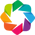

In [1]:
import numpy as np
import numba
import bebi103
import bokeh.plotting
import bokeh.io
import holoviews as hv
import pandas as pd

bokeh.io.output_notebook()
hv.extension('bokeh')

## Part (a)

Our goal in this part of the question is to create an MCMC sampler. First, we create a function that accepts or rejects an MCMC step. To do this in a general way, let's define a proposal distribution sampler, assuming the distribution is Gaussian:

In [2]:
def gaussian_proposal_sample(x0, sigma):
    # Returns a new x value ((1, n) array) given a starting coordinate (x0, (1, n) array)
    # and a multivariate sigma ((n, n) array).
    return np.random.multivariate_normal(x0, sigma)

Another convenient function to define is one that calculates the log of the proposal distribution at a given point. Again, we assume the proposal distribution is Gaussian:

In [3]:
def log_gaussian_proposal(x, x0, sigma):
    # Returns the log of a Gaussian distribution at x ((1, n) array) centered at
    # x0 ((1, n) array) with a multivariate sigma ((n, n) array).
    inv_cov = np.linalg.inv(sigma)
    return -np.dot((x-x0), np.dot(inv_cov, (x-x0))) / 2

Next, let's write a function to accept or reject an MCMC step, assuming a gaussian proposal distribution:

In [4]:
def mh_step(x, log_post, logpost_current, sigma, args=()):
    """
    Parameters
    ----------
    x : ndarray, shape (n_variables,)
        The present location of the walker in parameter space.
    log_post : function
        The function to compute the log posterior. It has call
        signature `log_post(x, *args)`.
    log_post_current : float
        The current value of the log posterior.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `log_post()` function.

    Returns
    -------
    x_out : ndarray, shape (n_variables,)
        The position of the walker after the Metropolis-Hastings
        step. If no step is taken, returns the inputted `x`.
    log_post_updated : float
        The log posterior after the step.
    accepted : bool
        True is the proposal step was taken, False otherwise.
    """
    # Generate a new x location
    new_x = gaussian_proposal_sample(x, sigma)
    
    # Find values relevant for calculating r
    log_proposal_old = log_gaussian_proposal(x, new_x, sigma)
    log_proposal_new = log_gaussian_proposal(new_x, x, sigma)
    log_post_new = log_post(new_x, *args)

    # Calculate r
    r = np.exp(log_post_new + log_proposal_old - logpost_current - log_proposal_new)
    
    # Perform accept/reject procedure
    if r >= 1:
        return (new_x, log_post_new, True)
    else:
        if np.random.random() < r:
            return (new_x, log_post_new, True)
        else:
            return (x, logpost_current, False)

Next, let's write a function that runs the MCMC using the sampler above:

In [5]:
def mh_sample(log_post, x0, sigma, args=(), n_burn=1000, n_steps=1000,
              variable_names=None):
    """
    Parameters
    ----------
    log_post : function
        The function to compute the log posterior. It has call
        signature `log_post(x, *args)`.
    x0 : ndarray, shape (n_variables,)
        The starting location of a walker in parameter space.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `log_post()` function.
    n_burn : int, default 1000
        Number of burn-in steps.
    n_steps : int, default 1000
        Number of steps to take after burn-in.
    variable_names : list, length n_variables
        List of names of variables. If None, then variable names
        are sequential integers.
    
    Returns
    -------
    output : DataFrame
        The first `n_variables` columns contain the samples.
        Additionally, column 'lnprob' has the log posterior value
        at each sample.
    """
    # Get current log posterior
    logpost_current = log_post(x0, *args)
    
    # Run burn steps
    while n_burn > 0:
        step_result = mh_step(x0, log_post, logpost_current, sigma, args)
        if step_result[2]:
            x0 = step_result[0]
            logpost_current = step_result[1]
            n_burn = n_burn - 1
    print("Done with burn.\nRunning %s steps..."%(n_steps))
    
    # Empty arrays to keep track of important quantities
    samples = []
    log_posteriors = []
    
    # Run MCMC step function and track results
    while n_steps > 0:
        step_result = mh_step(x0, log_post, logpost_current, sigma, args)
        if step_result[2]:
            x0 = step_result[0]
            logpost_current = step_result[1]
            n_steps = n_steps - 1
            samples.append(x0)
            log_posteriors.append(logpost_current)
    
    # Export dataframe
    results_df = pd.DataFrame(samples, columns = variable_names)
    results_df['lnprob'] = log_posteriors
    print("MCMC sampling finished.")
    return results_df

## Part (b)

Our goal in this question is to employ the MCMC sampler above on a multi-dimensional Gaussian proposal distribution.

First, let's create a bivariate Gaussian proposal distribution and check what it looks like:

In [6]:
# Axis bounds for plot
XMIN = 0
XMAX = 20
YMIN = 0
YMAX = 40

# Parameters for test function
mu = np.array([10.0, 20])
cov = np.array([[4, -2],[-2, 6]])
inv_cov = np.linalg.inv(cov)

# Define test distribution
def log_test_distribution(x, mu, inv_cov):
    """
    Unnormalized log posterior of a multivariate Gaussian.
    """
    return -np.dot((x-mu), np.dot(inv_cov, (x-mu))) / 2

# Create and populate plotting grid 
xs = np.linspace(XMIN, XMAX, 200)
ys = np.linspace(YMIN, YMAX, 200)
XS, YS = np.meshgrid(xs,ys)
ZS = np.zeros_like(XS)
for i in range(XS.shape[0]):
    for j in range(XS.shape[1]):
        ZS[i,j] = np.exp(log_test_distribution(np.array([XS[i,j],YS[i,j]]), mu, inv_cov))

# Plot the test distribution
p = bebi103.viz.contour(XS,YS,ZS,overlaid=True)
bokeh.io.show(p)

So now, we have a sense of what our MCMC results should look like. Let's try running the MCMC:

In [7]:
# Define starting point, kernel sigma, and initial log posterior
x0 = np.array([20,0])
kernel_sigma = np.array([[1,0],[0,1]])
args = (mu, inv_cov)
logpost_current = log_test_distribution(x0,*args)

# Run sampling with 10000 steps
test_result = mh_sample(log_test_distribution,
                        x0,
                        kernel_sigma,
                        args,
                        n_burn=1000,
                        n_steps=10000,
                        variable_names=['x','y'])

bokeh.io.show(bebi103.viz.corner(test_result, vars=['x', 'y'], plot_ecdf = True))

Done with burn.
Running 10000 steps...
MCMC sampling finished.


Just in case, let's look at the means and covariances:

In [8]:
print("x mean: %.2f" % (test_result.mean()['x']))
print("y mean: %.2f" % (test_result.mean()['y']))
test_result.cov().loc[['x','y'],['x','y']]

x mean: 10.06
y mean: 20.00


x         y
x  3.897317 -2.029087
y -2.029087  5.915491

<div class="alert alert-info">
Great Job! 60/60</div>

The means, covariances, and corner plot all correspond fairly well with the given test distribution, so we can move on to the next part.

## Part (c)

Let's rewrite the mh_sample function to enable tuning:

In [9]:
def mh_sample(log_post, x0, sigma, args=(), n_burn=1000, n_steps=1000,
              variable_names=None, tune_interval = 100, verbose = False):
    """
    Parameters
    ----------
    log_post : function
        The function to compute the log posterior. It has call
        signature `log_post(x, *args)`.
    x0 : ndarray, shape (n_variables,)
        The starting location of a walker in parameter space.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `log_post()` function.
    n_burn : int, default 1000
        Number of burn-in steps.
    n_steps : int, default 1000
        Number of steps to take after burn-in.
    variable_names : list, length n_variables
        List of names of variables. If None, then variable names
        are sequential integers.
    tune_interval : number of steps to calculate acceptance rate
        for tuning, default 100.
    verbose : boolean, determines whether to print acceptance rate
    
    Returns
    -------
    output : DataFrame
        The first `n_variables` columns contain the samples.
        Additionally, column 'lnprob' has the log posterior value
        at each sample.
    """
    # Create tuning variables that are accessible to the tune function
    mh_sample.tune_counter = 0
    mh_sample.accepts = 0
    
    # Perform tuning every tune_interval steps and modify sigma accordingly.
    # When tuning occurs, the number of acceptances is reset.
    def tune(sigma):
        mh_sample.tune_counter = (mh_sample.tune_counter + 1) % tune_interval
        if mh_sample.tune_counter != 0:
            return sigma
        a = mh_sample.accepts/tune_interval # accept rate
        if verbose:
            print("Accept rate: %.2f%%" % (a*100))
        mh_sample.accepts = 0
        scale = 1
        if a < 0.001:
            scale = 0.1
        elif a < 0.05:
            scale = 0.5
        elif a < 0.2:
            scale = 0.9
        elif a > 0.95:
            scale = 10
        elif a > 0.75:
            scale = 2
        elif a > 0.5:
            scale = 1.1
        return sigma * scale
    
    # Below is unchanged, except for commented lines
    
    logpost_current = log_post(x0, *args)
    
    while n_burn > 0:
        step_result = mh_step(x0, log_post, logpost_current, sigma, args)
        if step_result[2]:
            x0 = step_result[0]
            logpost_current = step_result[1]
            n_burn = n_burn - 1
            mh_sample.accepts += 1 # Add line to track acceptance
        sigma = tune(sigma) # Add line to perform tuning
            
    print("Done with burn.\nRunning %s steps..."%(n_steps))
    
    samples = []
    log_posteriors = []
    
    while n_steps > 0:
        step_result = mh_step(x0, log_post, logpost_current, sigma, args)
        if step_result[2]:
            x0 = step_result[0]
            logpost_current = step_result[1]
            n_steps = n_steps - 1
            mh_sample.accepts += 1 # Add line to track acceptance
            samples.append(x0)
            log_posteriors.append(logpost_current)
        sigma = tune(sigma) # Add line to perform tuning
    
    results_df = pd.DataFrame(samples, columns = variable_names)
    results_df['lnprob'] = log_posteriors
    print("MCMC sampling finished.")
    return results_df

We can see how the tuning rate hovers around 40% due to our tuning method:

In [10]:
tuning_result = mh_sample(log_test_distribution,
                          x0,
                          kernel_sigma,
                          args,
                          n_burn=1000,
                          n_steps=10000,
                          variable_names=['x','y'],
                          verbose = True)

Accept rate: 67.00%
Accept rate: 71.00%
Accept rate: 70.00%
Accept rate: 68.00%
Accept rate: 68.00%
Accept rate: 70.00%
Accept rate: 65.00%
Accept rate: 67.00%
Accept rate: 66.00%
Accept rate: 68.00%
Accept rate: 60.00%
Accept rate: 64.00%
Accept rate: 56.00%
Accept rate: 60.00%
Accept rate: 57.00%
Done with burn.
Running 10000 steps...
Accept rate: 49.00%
Accept rate: 63.00%
Accept rate: 58.00%
Accept rate: 50.00%
Accept rate: 45.00%
Accept rate: 56.00%
Accept rate: 58.00%
Accept rate: 53.00%
Accept rate: 45.00%
Accept rate: 44.00%
Accept rate: 44.00%
Accept rate: 53.00%
Accept rate: 38.00%
Accept rate: 45.00%
Accept rate: 45.00%
Accept rate: 51.00%
Accept rate: 41.00%
Accept rate: 37.00%
Accept rate: 49.00%
Accept rate: 41.00%
Accept rate: 52.00%
Accept rate: 39.00%
Accept rate: 39.00%
Accept rate: 33.00%
Accept rate: 48.00%
Accept rate: 39.00%
Accept rate: 44.00%
Accept rate: 43.00%
Accept rate: 47.00%
Accept rate: 48.00%
Accept rate: 36.00%
Accept rate: 40.00%
Accept rate: 36.00%
A

Let's plot the results to see if we got something reasonable:

In [11]:
bokeh.io.show(bebi103.viz.corner(tuning_result, vars=['x', 'y'], plot_ecdf = True))

<div class="alert alert-info">
Great Job! 10/10</div>

Looks good. Now let's move on to part (d):

## Part (d)

Here, we want to sample discrete variables, so we set up a multinomial distribution. Although bebi103.viz.contour isn't exactly the best way to visualize this, it does do level shading, so it gives some impression of what the distribution should look like.

In [12]:
from scipy.stats import multinomial

def log_test_distribution(x, n, probs):
    """
    Unnormalized log posterior of a multinomial distribution.
    """
    return multinomial.logpmf(x, n=n, p=probs)

# Define x and y ranges, as well as probabilities
xvals = np.linspace(0,10,11)
yvals = np.linspace(0,10,11)
probs = [0.5, 0.5]
X, Y = np.meshgrid(xvals, yvals)
Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = np.exp(log_test_distribution([X[i,j],Y[i,j]], 10, probs))
        
# Show level plot
p = bebi103.viz.contour(X,Y,Z,overlaid=True)
bokeh.io.show(p)

As we can see, it is a discrete distribution along a diagonal line. We change the proposal distribution to a flat distribution that can step each coordinate by -1, 0, or 1 with equal probability.

In [13]:
def mh_step(x, log_post, logpost_current, sigma, args=()):
    """
    Parameters
    ----------
    x : ndarray, shape (n_variables,)
        The present location of the walker in parameter space.
    log_post : function
        The function to compute the log posterior. It has call
        signature `log_post(x, *args)`.
    log_post_current : float
        The current value of the log posterior.
    sigma : ndarray, shape (n_variables, )
        The standard deviations for the proposal distribution.
    args : tuple
        Additional arguments passed to `log_post()` function.

    Returns
    -------
    x_out : ndarray, shape (n_variables,)
        The position of the walker after the Metropolis-Hastings
        step. If no step is taken, returns the inputted `x`.
    log_post_updated : float
        The log posterior after the step.
    accepted : bool
        True is the proposal step was taken, False otherwise.
    """
    # Step each coordinate by -1, 0, or 1 with equal probability
    new_x = [i + np.random.choice([-1,0,1]) for i in x]
    
    # Flat proposal distributions mean an unnormalized log proposal
    # distribution of 1 for all choices.
    log_proposal_old = 1
    log_proposal_new = 1
    
    log_post_new = log_post(new_x, *args)

    r = np.exp(log_post_new + log_proposal_old - logpost_current - log_proposal_new)
    
    if r >= 1:
        return (new_x, log_post_new, True)
    else:
        if np.random.random() < r:
            return (new_x, log_post_new, True)
        else:
            return (x, logpost_current, False)

Now, let's test the MCMC code. Note that the acceptance rate stays near 40%, as expected from our tuning algorithm.

In [14]:
# Include our arguments and an arbitrary starting position
args = (10, [0.5, 0.5])
x0 = [5, 5]

# (Note that sigma doesn't matter for this calculation because of our
#  redefinition of the proposal distribution.)
discrete_result = mh_sample(log_test_distribution,
                            x0,
                            kernel_sigma,
                            args,
                            n_burn=1000,
                            n_steps=10000,
                            variable_names=['x','y'])

Done with burn.
Running 10000 steps...
MCMC sampling finished.


To check if our result makes sense, we now plot the sampling results:

In [15]:
bokeh.io.show(bebi103.viz.corner(discrete_result, vars=['x', 'y'], plot_ecdf = True))

This looks reasonable, so this seems like a valid method for doing discrete MCMC.

<div class="alert alert-info">
Great Job! Another simple way to test a discrete distribution is to round the result from the Gaussian. 10/10</div>